### 1
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [16]:
total_covid_data = pd.read_csv('owid-covid-data.csv')

In [17]:
russian_covid = total_covid_data[total_covid_data['location'] == 'Russia']
russian_covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
214813,RUS,Europe,Russia,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214814,RUS,Europe,Russia,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214815,RUS,Europe,Russia,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214816,RUS,Europe,Russia,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214817,RUS,Europe,Russia,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


Итак, были выбраны данные по России. Легко видеть, что подвыборка данных начального периода не имеет никакого  
смысла для мини-исследрвания, так что избавимся от них, как и предложено в тексте задания.

In [19]:
russian_covid['date'] = pd.to_datetime(russian_covid['date'])  
russian_covid_act = russian_covid[russian_covid['date'] >= '2020-03-03']
russian_covid_act = russian_covid_act.replace({'new_cases' : {0.0 : 1.0}})
russian_covid_act.head()

C:\Users\User\AppData\Local\Temp\ipykernel_742884\96394108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  russian_covid['date'] = pd.to_datetime(russian_covid['date'])


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
214873,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214874,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214875,RUS,Europe,Russia,2020-03-05,3.0,1.0,0.143,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214876,RUS,Europe,Russia,2020-03-06,4.0,1.0,0.286,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214877,RUS,Europe,Russia,2020-03-07,4.0,1.0,0.286,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


Наконец, разделим подвыборку на train/test с соответсвии с заданием

In [20]:
threshold = russian_covid_act.iloc[0].date + pd.Timedelta("50 day")
train, test = (russian_covid_act[russian_covid_act['date'] < threshold], 
               russian_covid_act[russian_covid_act['date'] >= threshold])
print(test.shape)

(1053, 67)


Очевидно, что на тест не стоит брать данные за почти трехлетний период, когда сменилось уже несколько штаммов  
с разной степенью заразности. Чтобы отсечь границу, посмотрим целевой признак - число новых заражений.  
Допущение: отсечем все после появления омикрон-штамма (на этом моменте ожидается резкий пик).

In [21]:
def plot_feature(feature_name: str, 
                ylabel: str,
                title: str,
                slice_: int = -1) -> None:
    figsize = (18, 12)
    legend_fontsize = 10
    axis_fontsize = 16


    plt.plot(train.date, train[feature_name], label="train (50 days)", color='black')
    plt.plot(test.date[:slice_], test[feature_name][:slice_], label="test (others)", color='red')
    plt.xticks(rotation=25)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="upper left", fontsize=legend_fontsize)

    plt.show()

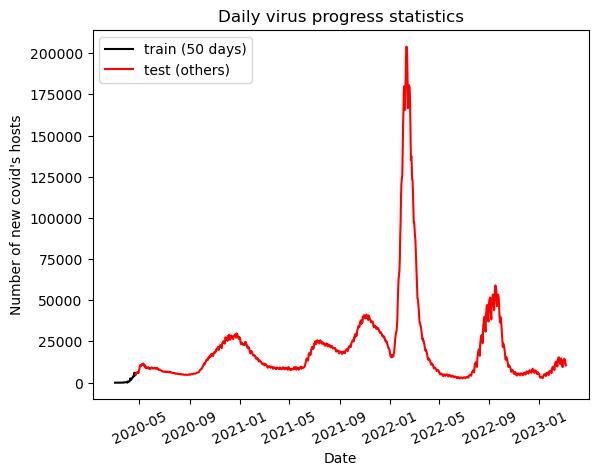

In [22]:
plot_feature(
    "new_cases",
    ylabel="Number of new covid's hosts",
    title='Daily virus progress statistics'
)

Посмотрим на целевой признак - число заражений по дням. Видим характерные пики - от оригинала до его "кентавров".  
Легко видеть (именно так), что оригинал закончился уже в январе 2021-го года, где уже наблбдается пик омикрона.  
Оценим грубо продожительность первоначального вируса в 1,5 года (или 540 дней).

In [23]:
test = test[:540]

### 2
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.  
a) Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.  
b) Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).  
c) Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).  


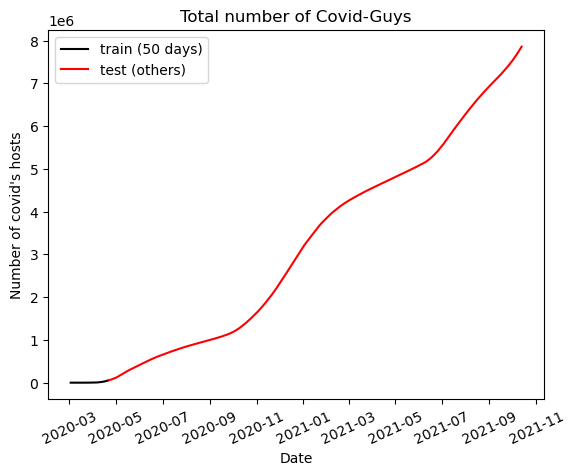

In [24]:
plot_feature(
    "total_cases",
    ylabel="Number of covid's hosts",
    title='Total number of Covid-Guys',
    slice_=540
)

Попробуем использовать экспоненту.  
Так как экспоненту наш питон не потянет (проверено), будем использовать логарифмическую шкалу

In [25]:
lr = LinearRegression()

x_train = np.arange(1, train.shape[0] + 1).reshape(-1, 1)
x_test = np.arange(train.shape[0] + 1, 
                   test.shape[0] + train.shape[0] +  1).reshape(-1, 1)

y_train = np.log(train["total_cases"]).values.reshape(-1, 1)
y_test = np.log(test["total_cases"]).values.reshape(-1, 1)

lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

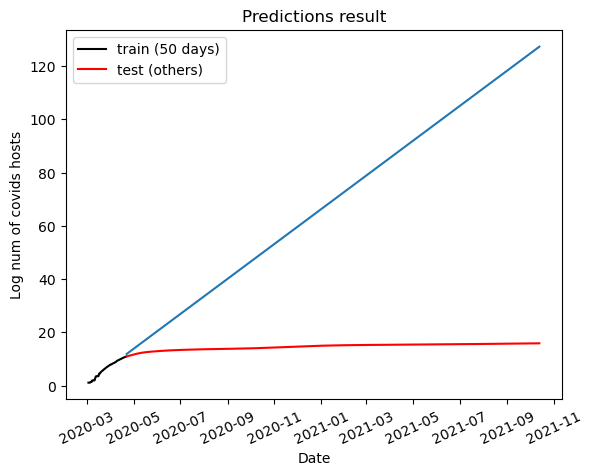

In [26]:
figsize = (18, 12)
legend_fontsize = 10
axis_fontsize = 16


plt.plot(train.date, y_train, label="train (50 days)", color='black')
plt.plot(test.date[:540], y_test, label="test (others)", color='red')
plt.plot(test.date[:540], lr_pred)
plt.xticks(rotation=25)
plt.xlabel("Date")
plt.ylabel('Log num of covids hosts')
plt.title('Predictions result')
plt.legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

Результат вполне ожидаем - совершенно не отражает результат на тесте. В чем же дело?  
Объяснение довольно просто - ограниченность популяции людей, доступных для заражения, что не учитывает модель.
Иначе говоря: интеграл от экспоненты расходится, поэтому вряд ли может описать зависимость, сходящуюсю к какой-то константе.

#### Пункт b

In [27]:
# Оценка дисперсии:
delta_arr = lr.predict(x_train) - y_train
sigma = np.std(delta_arr)
print(f'sigma is {sigma}')

sigma is 0.4498899109116322


In [28]:
cur_mu, cur_sigma = np.array([0, 0]), 10*np.array([[1, 0], [0, 1]])

Используем вспомогательную функцию из лекции, обновляющую апостериорное распределение по мере обновления данных

In [29]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [30]:
for i in range(train.shape[0]):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma,
                                        i, np.log(train.iloc[i]['total_cases']),
                                        sigma_noise=sigma)

In [31]:
print(f"mu is {cur_mu}")
print(f"sigma is {cur_sigma}")

mu is [1.19155684 0.2141627 ]
sigma is [[ 1.56911545e-02 -4.75489291e-04]
 [-4.75489291e-04  1.94155824e-05]]


#### Пункт с

In [32]:
def myplot_sample_lines(mu, sigma, xs, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
        
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


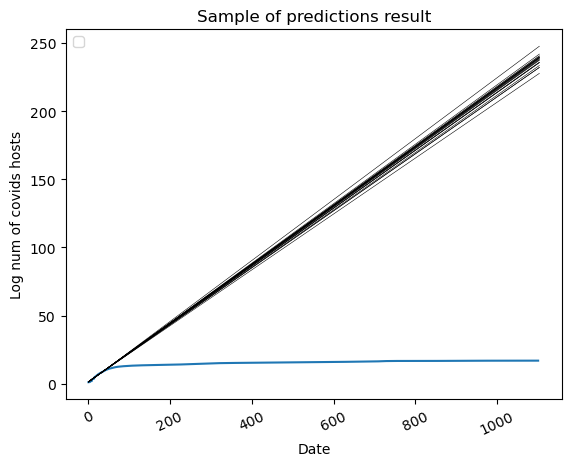

In [33]:
figsize = (18, 12)
legend_fontsize = 10
axis_fontsize = 16
x_all = np.arange(1, russian_covid_act.shape[0] + 1).reshape(-1, 1)
y_all = russian_covid_act['total_cases'].values.reshape(-1, 1)


plt.plot(x_all, np.log(y_all))
plt.xticks(rotation=25)
plt.xlabel("Date")
plt.ylabel('Log num of covids hosts')
plt.title('Sample of predictions result')
plt.legend(loc="upper left", fontsize=legend_fontsize)

myplot_sample_lines(cur_mu, cur_sigma, x_all)

Из сэмплирования можно сделать эмпирический вывод, что модель уверена в прогнозе; наблюдается низкая дисперсия  
между элементами "сэмпла".  
Посмотрим, какой результат даст этот прогноз на число заболевших к 1 мая, июня и сентября.

In [34]:
to_may = 59
to_june = 90
to_september = 182

sample_exponents = []
my_w = np.random.multivariate_normal(cur_mu, cur_sigma, 1000)
for w in my_w:
    sample_exponents.append(np.exp(w[0] + w[1] * x_all))
sample_exponents = np.array(sample_exponents)

print(f"1 May counters: {int(sample_exponents.mean(axis=0)[to_may][0])}")
print(f"1 June counters: {int(sample_exponents.mean(axis=0)[to_june][0])}")
print(f"1 September counters: {int(sample_exponents.mean(axis=0)[to_september][0])}")

1 May counters: 1280585
1 June counters: 1016604955
1 September counters: 462948355416995200


Итог: число заболевших на 1-е сентября примерно на 10 порядков превышает все население России.

### 3
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:  
 $$\large{Ф(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x e^{-\frac{t^2}{2}}\,dt}$$


Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.  
a)  Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.  
b)  Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.  
c)  Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?


#### Пункт a

Функция   $${Ф(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x e^{-\frac{t^2}{2}}\,dt}$$  
Представляет собой интеграл с переменным верхним пределом. Так как $$f(t) = e^{-\frac{t^2}{2}}$$ 
интегрируема на промежутке $[-\infty, +\infty]$ (а значит, непрерына в точке $x^*$ = x + $\delta x$), то мы можем применить теорему о производной интеграла.  

Таким образом, в точке $x^*$ = x + $\delta x$ $${Ф'(x^*) = f(x^*)}$$

При этом приращение имеет смысл увеличения числа ковидников за период времени, т.е "new_cases" в исходных данных.  
Таким образом, мы можем рассматривать подынтегральную функцию в качетсве "материала" для обучения линейной регрессии, предсказывая значения данной целевой переменной.  
Это крайне удобно, так как с данной функцией мы можем комфортно работать в логарифмическом масштабе, как и раньше.  
Добавим в показатель экспоненты линейный и константный признаки, получим:  $$g(t) = w_2t^2 + w_1t + w_0$$

#### Пункт b

In [84]:
lr2 = LinearRegression()

Для удобства введем два новых признака (в соответсвии с признаками модели)

In [95]:
russian_covid_act['day'] = np.arange(1, russian_covid_act.shape[0] + 1) # t
russian_covid_act['day_squared'] = np.arange(1, russian_covid_act.shape[0] + 1)**2 # t^2

train, test = (russian_covid_act[russian_covid_act['date'] < threshold], 
               russian_covid_act[russian_covid_act['date'] >= threshold])

In [96]:
# x_train = np.arange(1, train.shape[0] + 1).reshape(-1, 1)
# x_train_squared = x_train ** 2
# x_test = np.arange(train.shape[0] + 1, 
#                    test.shape[0] + train.shape[0] +  1).reshape(-1, 1)[:540]
# x_test_squared = x_test ** 2

# y_train = train["new_cases"].values.reshape(-1, 1)
# y_test = test["new_cases"].values.reshape(-1, 1)

# lr2.fit(pd.DataFrame(np.concatenate([x_train, x_train_squared]).reshape(-1, 2)), np.log(train['new_cases']))
# lr_pred = lr2.predict(pd.DataFrame(np.concatenate([x_test, x_test_squared]).reshape(-1, 2)))

Теперь получим итоговую модель

In [97]:
lr2.fit(train[['day', 'day_squared']], 
        np.log(train['new_cases'])
    );


In [103]:
delta_arr = lr2.predict(train[['day', 'day_squared']]) - np.log(train['new_cases'])
sigma = np.std(delta_arr)
print(f'sigma is {sigma}')

sigma is 1.1962232272133033


In [110]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.float64(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix)))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n
cur_mu = np.array([0, 0, 0])
cur_sigma = np.array([[50, 0, 0], [0, 50, 0], [0, 0, 50]])

In [111]:
for i in range(train.shape[0]):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma,
                                        i, np.log(train.iloc[i]['new_cases']),
                                        sigma_noise=sigma_noise)

In [112]:
print(f"mu is {cur_mu}")
print(f"sigma is {cur_sigma}")

mu is [-0.86832506  0.25793598 -0.00118443]
sigma is [[ 2.36881843e-01 -1.91384956e-02  3.22195068e-04]
 [-1.91384956e-02  2.11290983e-03 -4.03424129e-05]
 [ 3.22195068e-04 -4.03424129e-05  8.23759592e-07]]


#### Пункт c

In [118]:
def myplot_sample_lines(mu, sigma, xs, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(xs, np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * (xs**2))), 'k-', lw=.3)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
        
        
x_60 = russian_covid_act['day'].values.reshape(-1, 1)[:60]
y_60 = russian_covid_act['total_cases'].values.reshape(-1, 1)[:60]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


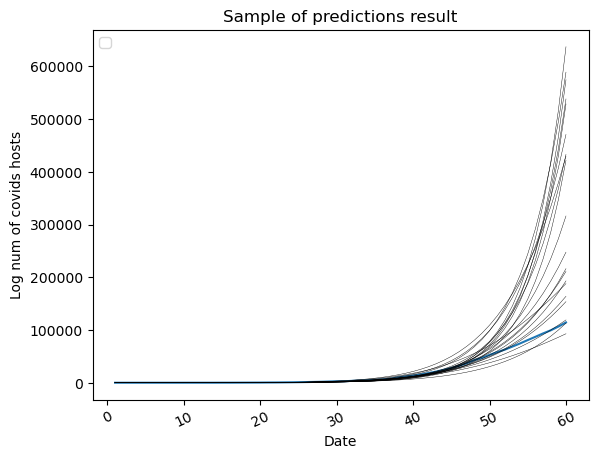

In [121]:
plt.plot(x_60, y_60)
plt.xticks(rotation=25)
plt.xlabel("Date")
plt.ylabel('Log num of covids hosts')
plt.title('Sample of predictions result')
plt.legend(loc="upper left", fontsize=legend_fontsize)

myplot_sample_lines(cur_mu, cur_sigma, x_60)

Хотя модель дает куда более релевантный результат, результат по-прежнему оставляет желать лучшего из-за смещения в показателе экеспоненты